<a href="https://colab.research.google.com/github/KelvinM9187/Blood-Cell-Classification-Dual-Transfer-Learning/blob/main/model0001.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Import necessary libraries
import os
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset, WeightedRandomSampler
from torchvision import models, transforms
from PIL import Image
import cv2
from google.colab import drive
import matplotlib.pyplot as plt
from tqdm import tqdm
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

In [ ]:
# Mount Google Drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Define dataset paths
DATASET_PATH = '/content/drive/MyDrive/DATASET/images'
TRAIN_DIR = os.path.join(DATASET_PATH, 'TRAIN')
TEST_DIR = os.path.join(DATASET_PATH, 'TEST')
CHECKPOINT_DIR = '/content/drive/MyDrive/checkpoints'
os.makedirs(CHECKPOINT_DIR, exist_ok=True)

In [ ]:
# Define classes
CLASSES = ['EOSINOPHIL', 'LYMPHOCYTE', 'MONOCYTE', 'NEUTROPHIL']
NUM_CLASSES = len(CLASSES)
class_to_idx = {cls: idx for idx, cls in enumerate(CLASSES)}


In [ ]:
# Gamma correction function
def adjust_gamma(image, gamma=1.0):
    invGamma = 1.0 / gamma
    table = np.array([((i / 255.0) ** invGamma) * 255 for i in np.arange(0, 256)]).astype("uint8")
    return cv2.LUT(image, table)

In [ ]:

# Custom Dataset with preprocessing
class BCCDDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.images = []
        self.labels = []

        for cls in CLASSES:
            cls_dir = os.path.join(root_dir, cls)
            for img_name in os.listdir(cls_dir):
                if img_name.endswith('.jpeg'):
                    self.images.append(os.path.join(cls_dir, img_name))
                    self.labels.append(class_to_idx[cls])

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img_path = self.images[idx]
        label = self.labels[idx]

        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

        img_lab = cv2.cvtColor(img, cv2.COLOR_RGB2LAB)
        l, a, b = cv2.split(img_lab)
        clahe = cv2.createCLAHE(clipLimit=3.0, tileGridSize=(16, 16))
        l = clahe.apply(l)
        img = cv2.merge((l, a, b))
        img = cv2.cvtColor(img, cv2.COLOR_LAB2RGB)

        img = adjust_gamma(img, gamma=0.8)
        img = Image.fromarray(img)

        if self.transform:
            img = self.transform(img)
        return img, label

In [ ]:
# Transforms
train_transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.RandomCrop(224),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomVerticalFlip(p=0.2),
    transforms.RandomRotation(30),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.RandomAffine(degrees=0, translate=(0.1, 0.1)),
    transforms.RandomPerspective(distortion_scale=0.2, p=0.2),
    transforms.GaussianBlur(kernel_size=3, sigma=(0.1, 0.5)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    transforms.RandomErasing(p=0.2, scale=(0.02, 0.1))
])

test_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])


In [ ]:
# Load datasets
train_dataset = BCCDDataset(TRAIN_DIR, transform=train_transform)
test_dataset = BCCDDataset(TEST_DIR, transform=test_transform)

In [ ]:
# Device setup
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Class weights and sampler
class_counts = [2497, 2483, 2478, 2499]
total_samples = sum(class_counts)
class_weights = [total_samples / (NUM_CLASSES * count) for count in class_counts]
class_weights_tensor = torch.tensor(class_weights).float().to(device)

labels = train_dataset.labels
weights = [class_weights_tensor[label] for label in labels]
sampler = WeightedRandomSampler(weights, len(weights), replacement=True)

In [ ]:
# Data loader
train_loader = DataLoader(train_dataset, batch_size=32, sampler=sampler, num_workers=2, pin_memory=True, persistent_workers=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=2, pin_memory=True, persistent_workers=True)

In [ ]:
# Focal Loss with label smoothing
class FocalLoss(nn.Module):
    def __init__(self, gamma=2.0, alpha=None, smoothing=0.1):
        super(FocalLoss, self).__init__()
        self.gamma = gamma
        self.alpha = alpha
        self.smoothing = smoothing

    def forward(self, inputs, targets):
        num_classes = inputs.size(-1)
        log_preds = F.log_softmax(inputs, dim=-1)

        if self.smoothing > 0:
            with torch.no_grad():
                true_dist = torch.zeros_like(log_preds)
                true_dist.fill_(self.smoothing / (num_classes - 1))
                true_dist.scatter_(1, targets.unsqueeze(1), 1.0 - self.smoothing)
            targets = true_dist

        ce_loss = -(targets * log_preds).sum(dim=-1)
        pt = torch.exp(-ce_loss)
        focal_loss = ((1 - pt) ** self.gamma) * ce_loss

        if self.alpha is not None:
            focal_loss *= self.alpha[targets.argmax(dim=1)]

        return focal_loss.mean()

In [ ]:
# Model definition
class BloodCellClassifier(nn.Module):
    def __init__(self, num_classes=4):
        super(BloodCellClassifier, self).__init__()
        self.resnet50 = models.resnet50(weights=models.ResNet50_Weights.DEFAULT)
        self.resnet50 = nn.Sequential(*list(self.resnet50.children())[:-2])
        self.efficientnet = models.efficientnet_b0(weights=models.EfficientNet_B0_Weights.DEFAULT)
        self.efficientnet = nn.Sequential(*list(self.efficientnet.children())[:-2])

        self.attention = nn.Sequential(
            nn.Conv2d(2048 + 1280, 512, kernel_size=1),
            nn.ReLU(),
            nn.Conv2d(512, 1, kernel_size=1),
            nn.Sigmoid()
        )

        self.classifier = nn.Sequential(
            nn.AdaptiveAvgPool2d(1),
            nn.Flatten(),
            nn.Linear(2048 + 1280, 1024),
            nn.BatchNorm1d(1024),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(1024, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(512, num_classes)
        )
        self._initialize_weights()


    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.Linear):
                nn.init.normal_(m.weight, 0, 0.01)
                nn.init.constant_(m.bias, 0)

    def forward(self, x):
        resnet_features = self.resnet50(x)
        efficientnet_features = self.efficientnet(x)
        efficientnet_features = F.interpolate(efficientnet_features, size=resnet_features.shape[2:], mode='bilinear', align_corners=False)
        fused_features = torch.cat((resnet_features, efficientnet_features), dim=1)
        attention_mask = self.attention(fused_features)
        attended_features = fused_features * attention_mask
        out = self.classifier(attended_features)
        return out

In [ ]:
# Instantiate model
model = BloodCellClassifier(num_classes=NUM_CLASSES).to(device)

# Optimizer and scheduler
optimizer = optim.AdamW(model.parameters(), lr=1e-4, weight_decay=1e-4)

def lr_lambda(epoch):
    warmup_epochs = 5
    return (epoch + 1) / warmup_epochs if epoch < warmup_epochs else 0.95 ** (epoch - warmup_epochs)

scheduler = optim.lr_scheduler.LambdaLR(optimizer, lr_lambda)

Downloading: "https://download.pytorch.org/models/resnet50-11ad3fa6.pth" to /root/.cache/torch/hub/checkpoints/resnet50-11ad3fa6.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 114MB/s]
Downloading: "https://download.pytorch.org/models/efficientnet_b0_rwightman-7f5810bc.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b0_rwightman-7f5810bc.pth
100%|██████████| 20.5M/20.5M [00:00<00:00, 75.6MB/s]


In [ ]:
# Checkpoint functions
def save_checkpoint(epoch, model, optimizer, loss, acc, train_losses, train_accs, test_losses, test_accs, filename):
    checkpoint = {
        'epoch': epoch,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'loss': loss,
        'acc': acc,
        'train_losses': train_losses,
        'train_accs': train_accs,
        'test_losses': test_losses,
        'test_accs': test_accs
    }
    torch.save(checkpoint, os.path.join(CHECKPOINT_DIR, filename))

def load_checkpoint(filename, model, optimizer):
    checkpoint = torch.load(os.path.join(CHECKPOINT_DIR, filename))
    model.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    return (
        checkpoint['epoch'],
        checkpoint['loss'],
        checkpoint.get('acc', 0.0),
        checkpoint.get('train_losses', []),
        checkpoint.get('train_accs', []),
        checkpoint.get('test_losses', []),
        checkpoint.get('test_accs', [])
    )

start_epoch = 0
train_losses, train_accs, test_losses, test_accs = [], [], [], []

if os.path.exists(os.path.join(CHECKPOINT_DIR, 'checkpoint.pth')):
    print("Resuming from checkpoint...")
    start_epoch, _, _, train_losses, train_accs, test_losses, test_accs = load_checkpoint('checkpoint.pth', model, optimizer)
    start_epoch += 1

Resuming from checkpoint...


In [ ]:
# Loss function
criterion = FocalLoss(gamma=2.0, alpha=class_weights_tensor, smoothing=0.1)

In [ ]:
def train_eval_model(model, train_loader, test_loader, criterion, optimizer, scheduler, num_epochs=50, start_epoch=0, train_losses=None, train_accs=None, test_losses=None, test_accs=None):
    if train_losses is None:
        train_losses = []
    if train_accs is None:
        train_accs = []
    if test_losses is None:
        test_losses = []
    if test_accs is None:
        test_accs = []

    best_acc = 0.0

    for epoch in range(start_epoch, num_epochs):
        model.train()
        running_loss, running_corrects = 0.0, 0

        print(f'\nEpoch {epoch+1}/{num_epochs}')
        for inputs, labels in tqdm(train_loader):
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()

            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            preds = torch.argmax(outputs, 1)
            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data)

        epoch_loss = running_loss / len(train_loader.dataset)
        epoch_acc = running_corrects.double() / len(train_loader.dataset)

        train_losses.append(epoch_loss)
        train_accs.append(epoch_acc.item())

        scheduler.step()

        model.eval()
        test_loss, test_corrects = 0.0, 0
        all_preds, all_labels = [], []

        with torch.no_grad():
            for inputs, labels in test_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)

                preds = torch.argmax(outputs, 1)
                test_loss += loss.item() * inputs.size(0)
                test_corrects += torch.sum(preds == labels.data)
                all_preds.extend(preds.cpu().numpy())
                all_labels.extend(labels.cpu().numpy())

        epoch_test_loss = test_loss / len(test_loader.dataset)
        epoch_test_acc = test_corrects.double() / len(test_loader.dataset)

        test_losses.append(epoch_test_loss)
        test_accs.append(epoch_test_acc.item())

        print(f'Train Loss: {epoch_loss:.4f}, Acc: {epoch_acc:.4f} | Test Loss: {epoch_test_loss:.4f}, Acc: {epoch_test_acc:.4f}')

        # Save best and current checkpoints
        if epoch_test_acc > best_acc:
            best_acc = epoch_test_acc
            save_checkpoint(epoch, model, optimizer, epoch_test_loss, epoch_test_acc.item(), train_losses, train_accs, test_losses, test_accs, 'best_model.pth')

        save_checkpoint(epoch, model, optimizer, epoch_test_loss, epoch_test_acc.item(), train_losses, train_accs, test_losses, test_accs, 'checkpoint.pth')

    return train_losses, train_accs, test_losses, test_accs

In [ ]:
def plot_results(train_losses, train_accs, test_losses, test_accs):
    epochs = range(1, len(train_losses) + 1)
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_losses, 'b-', label='Train Loss')
    plt.plot(epochs, test_losses, 'r-', label='Test Loss')
    plt.title('Loss per Epoch')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(epochs, train_accs, 'b-', label='Train Accuracy')
    plt.plot(epochs, test_accs, 'r-', label='Test Accuracy')
    plt.title('Accuracy per Epoch')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.tight_layout()
    plt.show()

In [ ]:
def evaluate_model(model, test_loader):
    model.eval()
    all_preds, all_labels = [], []

    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            preds = torch.argmax(outputs, 1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    print("\nClassification Report:\n")
    print(classification_report(all_labels, all_preds, target_names=CLASSES))

    cm = confusion_matrix(all_labels, all_preds)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=CLASSES, yticklabels=CLASSES)
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title('Confusion Matrix')
    plt.show()


Epoch 15/50


100%|██████████| 312/312 [20:43<00:00,  3.99s/it]


Train Loss: 0.3454, Acc: 0.7378 | Test Loss: 0.7077, Acc: 0.5549

Epoch 16/50


100%|██████████| 312/312 [09:02<00:00,  1.74s/it]


Train Loss: 0.3124, Acc: 0.7741 | Test Loss: 0.3981, Acc: 0.7008

Epoch 17/50


100%|██████████| 312/312 [05:30<00:00,  1.06s/it]


Train Loss: 0.3075, Acc: 0.7799 | Test Loss: 0.4733, Acc: 0.6848

Epoch 18/50


100%|██████████| 312/312 [04:12<00:00,  1.23it/s]


Train Loss: 0.2828, Acc: 0.8051 | Test Loss: 0.2019, Acc: 0.8669

Epoch 19/50


100%|██████████| 312/312 [04:04<00:00,  1.28it/s]


Train Loss: 0.2783, Acc: 0.8086 | Test Loss: 0.2418, Acc: 0.8440

Epoch 20/50


100%|██████████| 312/312 [03:51<00:00,  1.35it/s]


Train Loss: 0.2509, Acc: 0.8280 | Test Loss: 0.2250, Acc: 0.8689

Epoch 21/50


100%|██████████| 312/312 [03:56<00:00,  1.32it/s]


Train Loss: 0.2309, Acc: 0.8419 | Test Loss: 0.1729, Acc: 0.8910

Epoch 22/50


100%|██████████| 312/312 [03:54<00:00,  1.33it/s]


Train Loss: 0.2857, Acc: 0.8051 | Test Loss: 0.1658, Acc: 0.8818

Epoch 23/50


100%|██████████| 312/312 [03:46<00:00,  1.38it/s]


Train Loss: 0.2256, Acc: 0.8527 | Test Loss: 0.2441, Acc: 0.8303

Epoch 24/50


100%|██████████| 312/312 [03:46<00:00,  1.38it/s]


Train Loss: 0.2037, Acc: 0.8730 | Test Loss: 0.2141, Acc: 0.8701

Epoch 25/50


100%|██████████| 312/312 [03:47<00:00,  1.37it/s]


Train Loss: 0.1922, Acc: 0.8812 | Test Loss: 0.1807, Acc: 0.8906

Epoch 26/50


100%|██████████| 312/312 [03:47<00:00,  1.37it/s]


Train Loss: 0.1876, Acc: 0.8851 | Test Loss: 0.2267, Acc: 0.8472

Epoch 27/50


100%|██████████| 312/312 [03:49<00:00,  1.36it/s]


Train Loss: 0.1842, Acc: 0.8911 | Test Loss: 0.1757, Acc: 0.8910

Epoch 28/50


100%|██████████| 312/312 [03:48<00:00,  1.36it/s]


Train Loss: 0.1948, Acc: 0.8815 | Test Loss: 0.2275, Acc: 0.8593

Epoch 29/50


100%|██████████| 312/312 [03:49<00:00,  1.36it/s]


Train Loss: 0.1810, Acc: 0.8924 | Test Loss: 0.1761, Acc: 0.8914

Epoch 30/50


100%|██████████| 312/312 [03:57<00:00,  1.31it/s]


Train Loss: 0.1762, Acc: 0.8947 | Test Loss: 0.2109, Acc: 0.8733

Epoch 31/50


100%|██████████| 312/312 [03:47<00:00,  1.37it/s]


Train Loss: 0.1841, Acc: 0.8848 | Test Loss: 0.2108, Acc: 0.8786

Epoch 32/50


100%|██████████| 312/312 [03:47<00:00,  1.37it/s]


Train Loss: 0.1741, Acc: 0.8964 | Test Loss: 0.2126, Acc: 0.8830

Epoch 33/50


100%|██████████| 312/312 [03:49<00:00,  1.36it/s]


Train Loss: 0.1518, Acc: 0.9178 | Test Loss: 0.2846, Acc: 0.8372

Epoch 34/50


100%|██████████| 312/312 [03:49<00:00,  1.36it/s]


Train Loss: 0.1565, Acc: 0.9151 | Test Loss: 0.2536, Acc: 0.8629

Epoch 35/50


100%|██████████| 312/312 [03:47<00:00,  1.37it/s]


Train Loss: 0.1500, Acc: 0.9168 | Test Loss: 0.2492, Acc: 0.8717

Epoch 36/50


100%|██████████| 312/312 [03:48<00:00,  1.36it/s]


Train Loss: 0.1485, Acc: 0.9180 | Test Loss: 0.2823, Acc: 0.8693

Epoch 37/50


100%|██████████| 312/312 [03:46<00:00,  1.37it/s]


Train Loss: 0.1419, Acc: 0.9263 | Test Loss: 0.3041, Acc: 0.8456

Epoch 38/50


100%|██████████| 312/312 [03:46<00:00,  1.38it/s]


Train Loss: 0.1450, Acc: 0.9245 | Test Loss: 0.2168, Acc: 0.8926

Epoch 39/50


100%|██████████| 312/312 [03:56<00:00,  1.32it/s]


Train Loss: 0.1438, Acc: 0.9270 | Test Loss: 0.2474, Acc: 0.8826

Epoch 40/50


100%|██████████| 312/312 [03:46<00:00,  1.38it/s]


Train Loss: 0.1394, Acc: 0.9267 | Test Loss: 0.2661, Acc: 0.8693

Epoch 41/50


100%|██████████| 312/312 [03:46<00:00,  1.37it/s]


Train Loss: 0.1325, Acc: 0.9355 | Test Loss: 0.2586, Acc: 0.8794

Epoch 42/50


100%|██████████| 312/312 [03:48<00:00,  1.36it/s]


Train Loss: 0.1297, Acc: 0.9391 | Test Loss: 0.2978, Acc: 0.8798

Epoch 43/50


100%|██████████| 312/312 [03:45<00:00,  1.38it/s]


Train Loss: 0.1323, Acc: 0.9350 | Test Loss: 0.1986, Acc: 0.8910

Epoch 44/50


100%|██████████| 312/312 [03:46<00:00,  1.38it/s]


Train Loss: 0.1303, Acc: 0.9375 | Test Loss: 0.2675, Acc: 0.8556

Epoch 45/50


100%|██████████| 312/312 [03:46<00:00,  1.38it/s]


Train Loss: 0.1254, Acc: 0.9410 | Test Loss: 0.2572, Acc: 0.8733

Epoch 46/50


100%|██████████| 312/312 [03:47<00:00,  1.37it/s]


Train Loss: 0.1233, Acc: 0.9428 | Test Loss: 0.1885, Acc: 0.8930

Epoch 47/50


100%|██████████| 312/312 [03:54<00:00,  1.33it/s]


Train Loss: 0.1229, Acc: 0.9436 | Test Loss: 0.2878, Acc: 0.8581

Epoch 48/50


100%|██████████| 312/312 [03:45<00:00,  1.38it/s]


Train Loss: 0.1186, Acc: 0.9470 | Test Loss: 0.2645, Acc: 0.8701

Epoch 49/50


100%|██████████| 312/312 [03:42<00:00,  1.40it/s]


Train Loss: 0.1147, Acc: 0.9509 | Test Loss: 0.2816, Acc: 0.8770

Epoch 50/50


100%|██████████| 312/312 [03:44<00:00,  1.39it/s]


Train Loss: 0.1114, Acc: 0.9553 | Test Loss: 0.2957, Acc: 0.8749


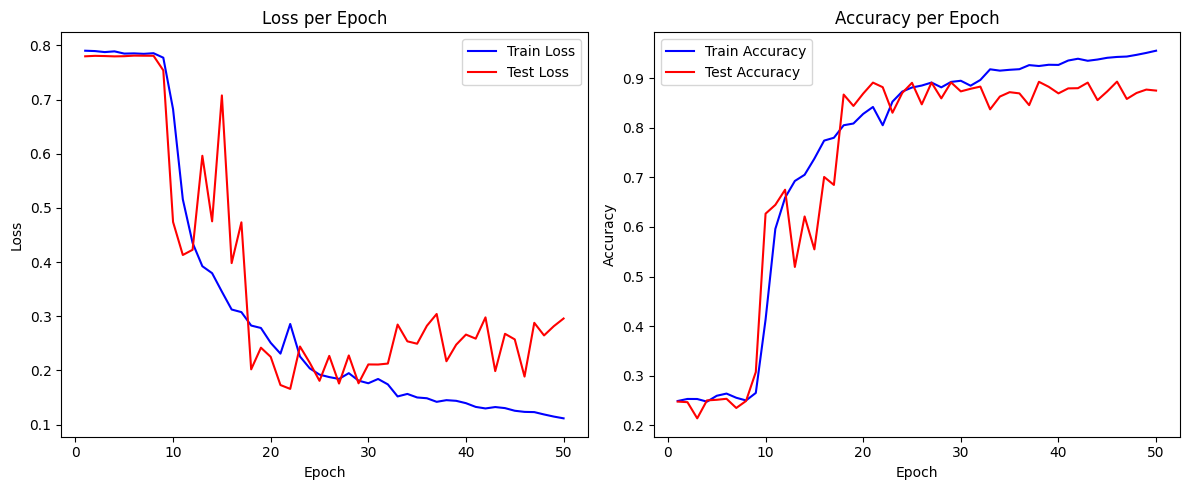


Classification Report:

              precision    recall  f1-score   support

  EOSINOPHIL       0.90      0.84      0.87       623
  LYMPHOCYTE       0.99      1.00      0.99       620
    MONOCYTE       0.99      0.83      0.90       620
  NEUTROPHIL       0.74      0.90      0.81       624

    accuracy                           0.89      2487
   macro avg       0.91      0.89      0.90      2487
weighted avg       0.91      0.89      0.90      2487



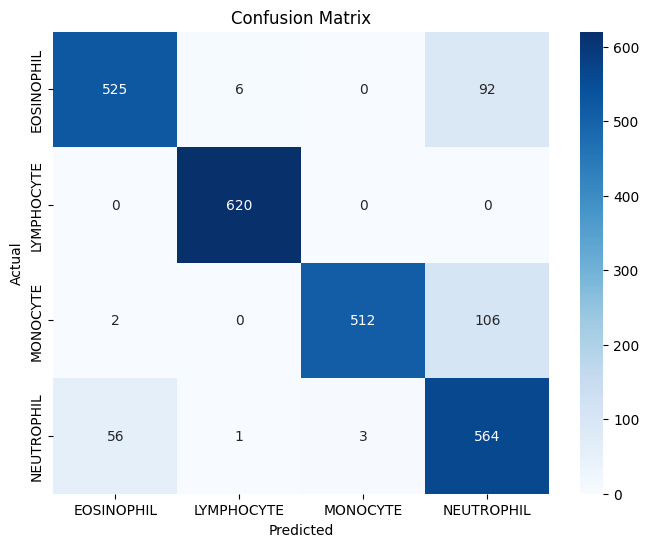

In [19]:
# Train model
train_losses, train_accs, test_losses, test_accs = train_eval_model(
    model, train_loader, test_loader, criterion, optimizer, scheduler,
    num_epochs=50, start_epoch=start_epoch,
    train_losses=train_losses, train_accs=train_accs,
    test_losses=test_losses, test_accs=test_accs
)

# Plot training and test metrics
plot_results(train_losses, train_accs, test_losses, test_accs)

# Load best model and evaluate
load_checkpoint('best_model.pth', model, optimizer)
evaluate_model(model, test_loader)